In [1]:
!pip install pandas_ml
!pip install scikit-learn==0.21
!pip install pandas==0.24.2

In [2]:
import keras
import cv2
import re
import os
import numpy as np
import matplotlib.pyplot as plt
import glob as glb
import pandas as pd
import tensorflow as tf
from __future__ import print_function
from sklearn.metrics import classification_report
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.utils import np_utils
from keras.utils import to_categorical
from pandas_ml import ConfusionMatrix
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adadelta
from keras import optimizers
from google.colab  import files, drive

drive.mount('/content/drive')

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


Mounted at /content/drive


In [3]:
def getCSV(resultat, path_output):
  """
  input : dict(result), str(path to csv)
  output : obj(df)
  """
  df = pd.DataFrame.from_dict(resultat, orient="index")
  # print(df)
  return df.to_csv(path_output, sep="\t", encoding="utf8")

## Ecriture des résultats

### Utilisation d'un dictionnaire avant de le transformer en dataframe

In [4]:
def getScoreLocuteur(report):
  """
  input : str(classification report)
  output : dict(scores)
  """
  lignes = report.split("\n")
  score = {}
  for n in range(1, len(lignes)):
    # print(lignes[n])
    if lignes[n] != "":
      lignes[n] = lignes[n].strip()
      if 'avg' in lignes[n]: lignes[n] = re.sub(" avg", "_avg",lignes[n])
      data = lignes[n].split()
      if data[0] != "accuracy":
        # print(data)
        score["precision_"+data[0]] = data[1]
        score["recall_"+data[0]] = data[2]
        score["f1_score_"+data[0]] = data[3]
        score["support_"+data[0]] = data[4]
      else:
        score["f1_score_"+data[0]] = data[1]
        score["support_"+data[0]] = data[2]

  return score

### Initiation d'une liste pour sauvegarder les identifiants des locuteurs

In [5]:
def getListLocuteur(path_to_files):
  """
  input : str(path to files)
  output : list(list of speakers)
  """
  locs = list()
  for path in glb.glob(path_to_files):
    loc_file = "_".join(path.split('/')[-1].split('_')[0:6])
    if loc_file not in locs:
      locs.append(loc_file)
  return locs

In [6]:
def getListSegment(path_to_files):
  """
  input : str(path to files)
  output : list(list of segments)
  """
  segments = list()
  for path in glb.glob(path_to_files):
    segment = path.split('/')[-1].split('_')[6]
    if segment not in segments:
      segments.append(segment)
  return segments

### Récupérations et transformations des données : les données à prédire

In [7]:
def getTestSetLocuteur(locuteur, path_input, img_rows=28, img_cols=28, num_classes=2):
  """
  input : str(id_locuteur), str(path to test files), int(image_rows), int(image_cols), int(number-classes)
  output : list(images), list(label)
  """
  x_test_loc = []
  y_test_loc = []
  fileNames_loc = []
  for path in glb.glob(path_input):
  #print(path)
    fileName = path.split('/')[-1]
  #print(fileName)
  #print(fileName.split('_'))
    if locuteur in fileName: 
      label = path.split('/')[-2]
      x = cv2.imread(path, 0).astype(np.uint8)
      x = cv2.resize(x, (img_rows, img_cols))
      y = dicoLocs[label]
      x_test_loc.append(x)
      y_test_loc.append(y)
      fileNames_loc.append(fileName)

  #print(len(x_test_loc))
  x_test_loc = np.array(x_test_loc)
  x_test_loc = x_test_loc.reshape(-1, x_test_loc.shape[1],x_test_loc.shape[2],1)
  x_test_loc = x_test_loc.astype('float32')
  x_test_loc /= 255. 

  y_test_loc = np.array(y_test_loc)
  y_test_loc = to_categorical(y_test_loc, num_classes, dtype='float32')
  return x_test_loc, y_test_loc, fileNames_loc

In [8]:
def getTestSetTroncons(tier, path_input, img_rows=28, img_cols=28, num_classes=2):
  """
  input : int(tier), str(path to test files), int(image_rows), int(image_cols), int(number-classes)
  output : list(images), list(label)
  """
  x_test_loc = []
  y_test_loc = []
  for path in glb.glob(path_input):
  #print(path)
    fileName = path.split('/')[-1]
  #print(fileName)
  #print(fileName.split('_'))
    tier = str(tier)
    if tier == fileName.split("_")[-1][0]:
      label = path.split('/')[-2]
      x = cv2.imread(path, 0).astype(np.uint8)
      x = cv2.resize(x, (img_rows, img_cols))
      y = dicoLocs[label]
      x_test_loc.append(x)
      y_test_loc.append(y)

  #print(len(x_test_loc))
  x_test_loc = np.array(x_test_loc)
  x_test_loc = x_test_loc.reshape(-1, x_test_loc.shape[1],x_test_loc.shape[2],1)
  x_test_loc = x_test_loc.astype('float32')
  x_test_loc /= 255. 

  y_test_loc = np.array(y_test_loc)
  y_test_loc = to_categorical(y_test_loc, num_classes, dtype='float32')
  return x_test_loc, y_test_loc

In [9]:
def getTestSetSegment(segment, path_input, img_rows=28, img_cols=28, num_classes=2):
  """
  input : str(segment), str(path to test files), int(image_rows), int(image_cols), int(number-classes)
  output : list(images), list(label)
  """
  x_test_seg = []
  y_test_seg = []
  for path in glb.glob(path_input):
  #print(path)
    fileName = path.split('/')[-1]
  #print(fileName)
  #print(fileName.split('_'))
    if segment in fileName.split('_')[6]: 
      label = path.split('/')[-2]
      x = cv2.imread(path, 0).astype(np.uint8)
      x = cv2.resize(x, (img_rows, img_cols))
      y = dicoLocs[label]
      x_test_seg.append(x)
      y_test_seg.append(y)

  #print(len(x_test_loc))
  x_test_seg = np.array(x_test_seg)
  x_test_seg = x_test_seg.reshape(-1, x_test_seg.shape[1],x_test_seg.shape[2],1)
  x_test_seg = x_test_seg.astype('float32')
  x_test_seg /= 255. 

  y_test_seg = np.array(y_test_seg)
  y_test_seg = to_categorical(y_test_seg, num_classes, dtype='float32')
  return x_test_seg, y_test_seg

## Initiation de la prédiction d'un modèle

In [10]:
def testLocuteur(model, path_output="drive/Shareddrives/ReseauNeurones/resume_resultats/all_score_loc.csv", path_input="drive/Shareddrives/ReseauNeurones/images/test/*/*"):
  """
  input : str(chemin vers les fichiers de test), str(chemin pour sauvegarder le fichier csv)
  output : df[col : scores, line : locuteur]
  """
  resultat = dict()
  locs = getListLocuteur(path_input)

  for locuteur in locs:
    x_test_loc, y_test_loc, fileNames = getTestSetLocuteur(locuteur, path_input)
    Y_test = np.argmax(y_test_loc, axis=1) # Convert one-hot to index
    y_pred = model.predict_classes(x_test_loc)
    resultat[locuteur] = getScoreLocuteur(classification_report(Y_test, y_pred))
    
    proba = model.predict(x_test_loc)
    print(proba)
    result_proba = dict()
    for i in range(len(proba)):
      score = dict()
      score["son"] = fileNames[i].split('_')[6]
      score["tier"] = fileNames[i].split('_')[-1][0]
      score["contexte_gauche"] = fileNames[i].split('_')[8]
      score["contexte_droit"] = fileNames[i].split('_')[9]
      score["contextes"] = fileNames[i].split('_')[8] + "_" + fileNames[i].split('_')[9]
      score["temps_debut"] = fileNames[i].split('_')[-3]
      score["temps_fin"] = fileNames[i].split('_')[-2]
      score["proba_oral"] = f"{proba[i][0]:.6f}"
      score["proba_nasal"] = f"{proba[i][1]:.6f}"
      result_proba[i+1] = score
    sortie_locuteur = "drive/Shareddrives/ReseauNeurones/resume_resultats/troncons/train_test_aAEI/locuteurs/" + locuteur + ".csv"
    print(sortie_locuteur)
    getCSV(result_proba, sortie_locuteur)
  return getCSV(resultat, path_output)

In [11]:
def testTroncons(model, path_output="drive/Shareddrives/ReseauNeurones/resume_resultats/all_score_loc.csv", path_input="drive/Shareddrives/ReseauNeurones/images/test/*/*"):
  """
  input : str(chemin vers les fichiers de test), str(chemin pour sauvegarder le fichier csv)
  output : df[col : scores, line : tier]
  """
  resultat = dict()
  troncons = [1, 2, 3]

  for tier in troncons:
    x_test_loc, y_test_loc = getTestSetTroncons(tier, path_input)
    Y_test = np.argmax(y_test_loc, axis=1) # Convert one-hot to index
    y_pred = model.predict_classes(x_test_loc)
    resultat[tier] = getScoreLocuteur(classification_report(Y_test, y_pred))

  return getCSV(resultat, path_output)

In [12]:
def testSegment(model, path_output="drive/Shareddrives/ReseauNeurones/resume_resultats/all_score_loc.csv", path_input="drive/Shareddrives/ReseauNeurones/images/test/*/*"):
  """
  input : str(chemin vers les fichiers de test), str(chemin pour sauvegarder le fichier csv)
  output : df[col : scores, line : locuteur]
  """
  resultat = dict()
  segments = getListSegment(path_input)
  print(segments)
  for seg in segments:
    x_test_seg, y_test_seg = getTestSetSegment(seg, path_input)
    Y_test = np.argmax(y_test_seg, axis=1) # Convert one-hot to index
    y_pred = np.argmax(model.predict(x_test_seg), axis=-1)
    resultat[seg] = getScoreLocuteur(classification_report(Y_test, y_pred))

  return getCSV(resultat, path_output)

In [ ]:
x_test_troncons1 = list()
y_test_troncons1 = list()

x_test_troncons2 = list()
y_test_troncons2 = list()

x_test_troncons3 = list()
y_test_troncons3 = list()

resultat = dict()

for path in glb.glob("/content/drive/Shareddrives/ReseauNeurones/images_troncons/test_aA_et_EI/*/*"):
  #print(path)
    fileName = path.split('/')[-1]
  #print(fileName)
  #print(fileName.split('_'))
    if "1" == fileName.split("_")[-1][0]:
      label = path.split('/')[-2]
      x = cv2.imread(path, 0).astype(np.uint8)
      x = cv2.resize(x, (img_rows, img_cols))
      y = dicoLocs[label]
      x_test_troncons1.append(x)
      y_test_troncons1.append(y)
    elif "2" == fileName.split("_")[-1][0]:
      label = path.split('/')[-2]
      x = cv2.imread(path, 0).astype(np.uint8)
      x = cv2.resize(x, (img_rows, img_cols))
      y = dicoLocs[label]
      x_test_troncons2.append(x)
      y_test_troncons2.append(y)
    elif "3" == fileName.split("_")[-1][0]:
      label = path.split('/')[-2]
      x = cv2.imread(path, 0).astype(np.uint8)
      x = cv2.resize(x, (img_rows, img_cols))
      y = dicoLocs[label]
      x_test_troncons3.append(x)
      y_test_troncons3.append(y)

  #print(len(x_test_loc))
x_test_troncons1 = np.array(x_test_troncons1)
x_test_troncons1 = x_test_troncons1.reshape(-1, x_test_troncons1.shape[1],x_test_troncons1.shape[2],1)
x_test_troncons1 = x_test_troncons1.astype('float32')
x_test_troncons1 /= 255. 

y_test_troncons1 = np.array(y_test_troncons1)
y_test_troncons1 = to_categorical(y_test_troncons1, 2, dtype='float32')

# 2
x_test_troncons2 = np.array(x_test_troncons2)
x_test_troncons2 = x_test_troncons2.reshape(-1, x_test_troncons2.shape[1],x_test_troncons2.shape[2],1)
x_test_troncons2 = x_test_troncons2.astype('float32')
x_test_troncons2 /= 255. 

y_test_troncons2 = np.array(y_test_troncons2)
y_test_troncons2 = to_categorical(y_test_troncons2, 2, dtype='float32')

# 3
x_test_troncons3 = np.array(x_test_troncons3)
x_test_troncons3 = x_test_troncons3.reshape(-1, x_test_troncons3.shape[1],x_test_troncons3.shape[2],1)
x_test_troncons3 = x_test_troncons3.astype('float32')
x_test_troncons3 /= 255. 

y_test_troncons3 = np.array(y_test_troncons3)
y_test_troncons3 = to_categorical(y_test_troncons3, 2, dtype='float32')



## Récupérations et transformations des données pour construire un modèle

In [13]:
def getDataSet(path_input, img_rows=28, img_cols=28, num_classes=2):
  """
  input : str(id_locuteur), str(path to test files), int(image_rows), int(image_cols), int(number-classes)
  output : list(images), list(label)
  """
  x_data = []
  y_data = []
  fileNames = []
  
  for path in glb.glob(path_input) :
    label = path.split('/')[-2] #nasalité
    x = cv2.imread(path, 0).astype(np.uint8) 
    x = cv2.resize(x, (img_rows, img_cols)) 
    y = dicoLocs[label]
    x_data.append(x) 
    y_data.append(y)
    fileNames.append(path.split('/')[-1])

  x_data = np.array(x_data)
  x_data = x_data.reshape(-1, x_data.shape[1],x_data.shape[2],1)
  x_data = x_data.astype('float32')
  x_data /= 255. 

  y_data = np.array(y_data)
  y_data = to_categorical(y_data, num_classes, dtype='float32')
  
  return x_data, y_data, fileNames

## Construction du classifieur

In [14]:
def keras_RN(x_train, y_train, x_test, y_test, activation, loss, optimizer, num_classes=2, batch_size=10, epochs=115, verbose=1):
  model = Sequential()
  model.add(Conv2D(32, kernel_size=(5,5),
                  activation=activation,
                  input_shape=(img_rows, img_cols, 1)))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Conv2D(64, (5, 5), activation='tanh'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Flatten())
  model.add(Dense(num_classes, activation='softmax'))
  model.summary()
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
  mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)

  model.compile(loss=loss,
              optimizer=optimizer,
              metrics=['accuracy'])

  history = model.fit(x_train, y_train,
            batch_size=batch_size,
            epochs=epochs,
            verbose=verbose,
            validation_data=(x_test, y_test), 
            callbacks=[es,mc])

  score = model.evaluate(x_test, y_test, verbose=0)
  print('Test loss:', score[0])
  print('Test accuracy:', score[1])

  best_model=keras.models.load_model('best_model.h5')
  test_loss, test_acc = best_model.evaluate(x_test, y_test)
  val_loss_list=history.history['val_loss']
  best_val_loss_epoch=val_loss_list.index(min(val_loss_list))
  val_acc_list = history.history["val_accuracy"]
  best_val_acc_epoch = val_acc_list.index(max(val_acc_list))

  print("loss on test set : ", test_loss)
  print("accuracy on test set : ", test_acc)
  print("\nBest epoch for the val_loss is : ", best_val_loss_epoch)
  print("\nBest epoch for the val_acc is : ", best_val_acc_epoch)

  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

  Y_test = np.argmax(y_test, axis=1) # Convert one-hot to index
  y_pred = model.predict_classes(x_test)
  print(classification_report(Y_test, y_pred))
  
  return model


Hyperparamètres pour le RN

In [15]:
dicoLocs = {'nasal':1, 'non_nasal':0}
labels = [l.split('/')[-1] for l in glb.glob('drive/Shareddrives/ReseauNeurones/images_troncons/train/*')]
img_rows, img_cols = 28, 28
batch_size = 10
epochs = 115
num_classes = len(labels)

In [ ]:
print(dicoLocs)
print(labels)

{'nasal': 1, 'non_nasal': 0}
['nasal', 'non_nasal']


Les données - images et labels

In [ ]:
x_train, y_train, fileNames_train = getDataSet('/content/drive/Shareddrives/ReseauNeurones/images_troncons/train_aA_et_EI/*/*')
x_test, y_test, fileNames = getDataSet('/content/drive/Shareddrives/ReseauNeurones/images_troncons/test_aA_et_EI/*/*')

In [ ]:
for path in glb.glob('drive/Shareddrives/ReseauNeurones/images_troncons/test/*/*') :
  fileName = path.split('/')[-1]
  #print(fileName)
  #print(fileName.split('_'))
  tier = str(1)
  # print(fileName)
  # print(fileName.split("_")[-1])
  if tier == fileName.split("_")[-1][0]:
    print(fileName)

In [ ]:
print(len(x_train), len(x_test))
print(y_train)

print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

28080 6480
[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]
x_train shape: (28080, 28, 28, 1)
x_test shape: (6480, 28, 28, 1)
28080 train samples
6480 test samples


# Exécution du modèle

##Entraînement 1
    activation : tanh
    model.compile(loss='mean_squared_error', optimizer=sgd, metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 64)          51264     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2050      
Total params: 54,146
Trainable params: 54,146
Non-trainable params: 0
__________________________________________________

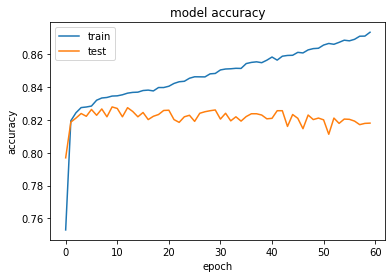

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.84      0.79      0.81      3240
           1       0.80      0.85      0.82      3240

    accuracy                           0.82      6480
   macro avg       0.82      0.82      0.82      6480
weighted avg       0.82      0.82      0.82      6480



In [ ]:
model = keras_RN(x_train, y_train, x_test, y_test, activation="tanh", loss="mean_squared_error", optimizer=optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True))

In [ ]:
model.save('/content/drive/Shareddrives/ReseauNeurones/resume_resultats/models/troncons_train_test_aAEI_model1')

INFO:tensorflow:Assets written to: /content/drive/Shareddrives/ReseauNeurones/resume_resultats/models/troncons_train_test_aAEI_model1/assets


In [ ]:
model = tf.keras.models.load_model('/content/drive/Shareddrives/ReseauNeurones/resume_resultats/models/troncons_train_test_aAEI_model1')

(-0.5, 1.5, 1.5, -0.5)

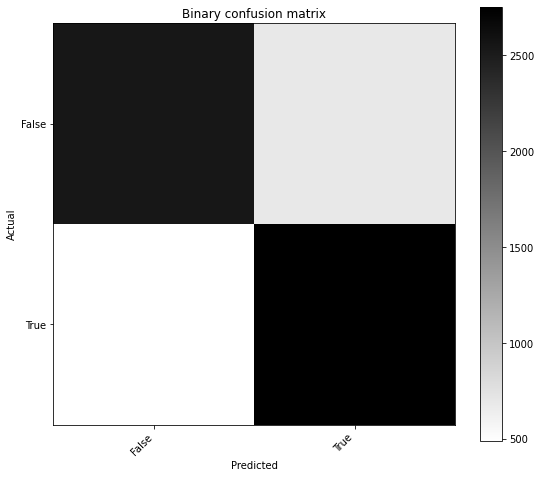

In [ ]:
predictions = model.predict(np.array(x_test), batch_size=100)
ConfusionMatrix(np.array(y_test.argmax(axis=1)), predictions.argmax(axis=1)).plot().axis('on')

In [ ]:
testLocuteur(model, "/content/drive/Shareddrives/ReseauNeurones/resume_resultats/troncons/train_test_aAEI/all_score_loc_entrainement1.csv", "/content/drive/Shareddrives/ReseauNeurones/images_troncons/test_aA_et_EI/*/*")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
 [1.42631844e-01 8.57368112e-01]
 [6.31946744e-03 9.93680477e-01]
 [1.42631844e-01 8.57368112e-01]
 [2.13274546e-03 9.97867227e-01]
 [1.42631844e-01 8.57368112e-01]
 [2.68996111e-03 9.97310042e-01]
 [1.42631844e-01 8.57368112e-01]
 [1.21073194e-01 8.78926873e-01]
 [1.42631844e-01 8.57368112e-01]
 [1.42631873e-01 8.57368112e-01]
 [2.77439915e-02 9.72255945e-01]
 [5.60984202e-03 9.94390190e-01]
 [1.39232874e-02 9.86076713e-01]
 [8.17071088e-03 9.91829216e-01]
 [8.44816118e-02 9.15518343e-01]
 [5.03030140e-03 9.94969666e-01]
 [4.11545821e-02 9.58845437e-01]
 [1.42631873e-01 8.57368112e-01]
 [1.42631844e-01 8.57368112e-01]
 [2.89416756e-03 9.97105777e-01]
 [1.88986659e-02 9.81101394e-01]
 [1.42631873e-01 8.57368112e-01]
 [6.10659318e-03 9.93893325e-01]
 [6.00926718e-03 9.93990779e-01]
 [2.03595627e-02 9.79640424e-01]
 [1.42631873e-01 8.57368112e-01]
 [1.42631844e-01 8.57368112e-01]
 [1.42631873e-01 8.57368112e-01

In [ ]:
testSegment(model, "/content/drive/Shareddrives/ReseauNeurones/resume_resultats/troncons/train_test_aAEI/all_score_seg_entrainement1.csv", "/content/drive/Shareddrives/ReseauNeurones/images_troncons/test_aA_et_EI/*/*")

['a', 'E', 'A', 'I']


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [ ]:
Y_test = np.argmax(y_test_troncons1, axis=1) # Convert one-hot to index
y_pred = model.predict_classes(x_test_troncons1)
resultat["1"] = getScoreLocuteur(classification_report(Y_test, y_pred))

# 2
Y_test = np.argmax(y_test_troncons2, axis=1) # Convert one-hot to index
y_pred = model.predict_classes(x_test_troncons2)
resultat["2"] = getScoreLocuteur(classification_report(Y_test, y_pred))

# 3
Y_test = np.argmax(y_test_troncons3, axis=1) # Convert one-hot to index
y_pred = model.predict_classes(x_test_troncons3)
resultat["3"] = getScoreLocuteur(classification_report(Y_test, y_pred))

getCSV(resultat, "/content/drive/Shareddrives/ReseauNeurones/resume_resultats/troncons/train_test_aAEI/all_score_tier_entrainement1.csv")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
proba = model.predict(x_test)
print(proba)

[[0.14263187 0.8573681 ]
 [0.2942163  0.7057837 ]
 [0.14263187 0.8573681 ]
 ...
 [0.14263184 0.8573681 ]
 [0.03095414 0.96904594]
 [0.03903733 0.96096265]]


In [ ]:
print(proba[0])
for i in proba[0]:
  print(f"{i:.6f}")

[0.14263187 0.8573681 ]
0.142632
0.857368


In [ ]:
print(fileNames[0].split('_'))

['26', '11', '07', 'nb3', '2', '16', 'a', '2111', 'labial', 'dorsal', '261.85566666666665', '261.8923333333333', '2.png']


In [ ]:
resultat = dict()

for i in range(len(proba)):
  score = dict()
  score["son"] = fileNames[i].split('_')[6]
  score["tier"] = fileNames[i].split('_')[-1][0]
  score["contexte_gauche"] = fileNames[i].split('_')[8]
  score["contexte_droit"] = fileNames[i].split('_')[9]
  score["contextes"] = fileNames[i].split('_')[8] + "_" + fileNames[i].split('_')[9]
  score["temps_debut"] = fileNames[i].split('_')[-3]
  score["temps_fin"] = fileNames[i].split('_')[-2]
  score["proba_oral"] = f"{proba[i][0]:.6f}"
  score["proba_nasal"] = f"{proba[i][1]:.6f}"
  resultat[i+1] = score

getCSV(resultat, "drive/Shareddrives/ReseauNeurones/resume_resultats/troncons/train_test_aAEI/all_score_context_entrainement1.csv")

In [ ]:
resultat = dict()

# Entraînement en retirant 5 locuteurs - 1


In [16]:
path_input = 'drive/Shareddrives/ReseauNeurones/images_troncons/train_aA_et_EI/*/*'
locs = getListLocuteur(path_input)
locs_40 = locs[5:]
locs_5 = locs[:5]
comp_40 = 0
print(locs_5)
print(locs_40)
x_train_locs_40, y_train_locs_40 = [], []
x_test_locs_5, y_test_locs_5 = [], []
fileNames = []
fileNames_test = []
for locuteur in locs_40:
  for path in glb.glob(path_input):
    if locuteur in path.split('/')[-1]:
      label = path.split('/')[-2]
      x = cv2.imread(path, 0).astype(np.uint8)
      x = cv2.resize(x, (img_rows, img_cols))
      y = dicoLocs[label]
      x_train_locs_40.append(x)
      y_train_locs_40.append(y)
      fileNames.append(path.split('/')[-1])

#print(len(x_test_loc))
x_train_locs_40 = np.array(x_train_locs_40)
x_train_locs_40 = x_train_locs_40.reshape(-1, x_train_locs_40.shape[1],x_train_locs_40.shape[2],1)
x_train_locs_40 = x_train_locs_40.astype('float32')
x_train_locs_40 /= 255. 

y_train_locs_40 = np.array(y_train_locs_40)
y_train_locs_40 = to_categorical(y_train_locs_40, num_classes, dtype='float32')

for locuteur in locs_5:
  for path in glb.glob(path_input):
    fileName = path.split('/')[-1]
    if locuteur in fileName:
      label = path.split('/')[-2]
      x = cv2.imread(path, 0).astype(np.uint8)
      x = cv2.resize(x, (img_rows, img_cols))
      y = dicoLocs[label]
      x_test_locs_5.append(x)
      y_test_locs_5.append(y)
      fileNames_test.append(fileName)
  
# #print(len(x_test_loc))
x_test_locs_5 = np.array(x_test_locs_5)
x_test_locs_5 = x_test_locs_5.reshape(-1, x_test_locs_5.shape[1],x_test_locs_5.shape[2],1)
x_test_locs_5 = x_test_locs_5.astype('float32')
x_test_locs_5 /= 255. 

y_test_locs_5 = np.array(y_test_locs_5)
y_test_locs_5 = to_categorical(y_test_locs_5, num_classes, dtype='float32')


print(len(x_train_locs_40), len(y_train_locs_40), len(fileNames))
print(len(x_test_locs_5), len(y_test_locs_5), len(fileNames_test))


['29_11_07_nb2_1_16', '29_11_07_nb2_2_16', '30_11_07_nb1_1_16', '30_11_07_nb1_2_16', '28_11_07_nb2_1_16']
['28_11_07_nb2_2_16', '29_11_07_nb1_2_16', '27_11_07_nb2_2_16', '28_11_07_nb1_1_16', '28_11_07_nb1_2_16', '27_11_07_nb1_1_16', '27_11_07_nb1_2_16', '27_11_07_nb2_1_16', '26_11_07_nb2_1_16', '26_11_07_nb2_2_16', '26_11_07_nb3_1_16', '26_11_07_nb3_2_16', '23_11_07_nb1_2_16', '26_11_07_nb1_1_16', '26_11_07_nb1_2_16', '22_11_07_nb2_1_16', '22_11_07_nb2_2_16', '23_11_07_nb1_1_16', '20_11_07_nb1_2_16', '22_11_07_nb1_1_16', '22_11_07_nb1_2_16', '16_11_07_nb2_1_16', '16_11_07_nb2_2_16', '20_11_07_nb1_1_16', '14_11_07_nb2_1_16', '14_11_07_nb2_2_16', '16_11_07_nb1_1_16', '16_11_07_nb1_2_16', '05_12_07_nb1_2_16', '14_11_07_nb1_1_16', '14_11_07_nb1_2_16', '04_12_07_nb3_1_16', '04_12_07_nb3_2_16', '05_12_07_nb1_1_16', '04_12_07_nb1_2_16', '04_12_07_nb2_1_16', '04_12_07_nb2_2_16', '03_12_07_nb1_1_16', '03_12_07_nb1_2_16', '04_12_07_nb1_1_16']
24960 24960 24960
3120 3120 3120


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 64)          51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 2050      
Total params: 54,146
Trainable params: 54,146
Non-trainable params: 0
____________________________________________________

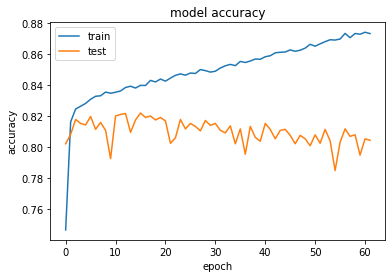

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.83      0.77      0.80      1560
           1       0.78      0.84      0.81      1560

    accuracy                           0.80      3120
   macro avg       0.81      0.80      0.80      3120
weighted avg       0.81      0.80      0.80      3120



In [17]:
model = keras_RN(x_train_locs_40, y_train_locs_40, x_test_locs_5, y_test_locs_5, activation="tanh", loss="mean_squared_error", optimizer=optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True))

In [18]:
model.save('/content/drive/Shareddrives/ReseauNeurones/resume_resultats/models/troncons_train_test_aAEI_sans_5locs_model1')

INFO:tensorflow:Assets written to: /content/drive/Shareddrives/ReseauNeurones/resume_resultats/models/troncons_train_test_aAEI_sans_5locs_model1/assets


(-0.5, 1.5, 1.5, -0.5)

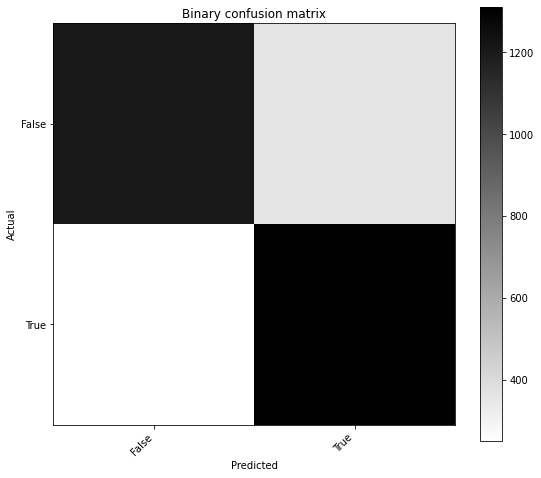

In [19]:
predictions = model.predict(np.array(x_test_locs_5), batch_size=100)
ConfusionMatrix(np.array(y_test_locs_5.argmax(axis=1)), predictions.argmax(axis=1)).plot().axis('on')

# Entraînement en retirant 5 locuteurs - 2



In [20]:
path_input = 'drive/Shareddrives/ReseauNeurones/images_troncons/train_aA_et_EI/*/*'
locs = getListLocuteur(path_input)
locs_40 = locs[10:] + locs[:5]
locs_5 = locs[5:10]
comp_40 = 0
print(locs_5)
print(locs_40)
x_train_locs_40, y_train_locs_40 = [], []
x_test_locs_5, y_test_locs_5 = [], []
fileNames = []
fileNames_test = []
for locuteur in locs_40:
  for path in glb.glob(path_input):
    if locuteur in path.split('/')[-1]:
      label = path.split('/')[-2]
      x = cv2.imread(path, 0).astype(np.uint8)
      x = cv2.resize(x, (img_rows, img_cols))
      y = dicoLocs[label]
      x_train_locs_40.append(x)
      y_train_locs_40.append(y)
      fileNames.append(path.split('/')[-1])

#print(len(x_test_loc))
x_train_locs_40 = np.array(x_train_locs_40)
x_train_locs_40 = x_train_locs_40.reshape(-1, x_train_locs_40.shape[1],x_train_locs_40.shape[2],1)
x_train_locs_40 = x_train_locs_40.astype('float32')
x_train_locs_40 /= 255. 

y_train_locs_40 = np.array(y_train_locs_40)
y_train_locs_40 = to_categorical(y_train_locs_40, num_classes, dtype='float32')

for locuteur in locs_5:
  for path in glb.glob(path_input):
    fileName = path.split('/')[-1]
    if locuteur in fileName:
      label = path.split('/')[-2]
      x = cv2.imread(path, 0).astype(np.uint8)
      x = cv2.resize(x, (img_rows, img_cols))
      y = dicoLocs[label]
      x_test_locs_5.append(x)
      y_test_locs_5.append(y)
      fileNames_test.append(fileName)
  
# #print(len(x_test_loc))
x_test_locs_5 = np.array(x_test_locs_5)
x_test_locs_5 = x_test_locs_5.reshape(-1, x_test_locs_5.shape[1],x_test_locs_5.shape[2],1)
x_test_locs_5 = x_test_locs_5.astype('float32')
x_test_locs_5 /= 255. 

y_test_locs_5 = np.array(y_test_locs_5)
y_test_locs_5 = to_categorical(y_test_locs_5, num_classes, dtype='float32')


print(len(x_train_locs_40), len(y_train_locs_40), len(fileNames))
print(len(x_test_locs_5), len(y_test_locs_5), len(fileNames_test))


['28_11_07_nb2_2_16', '29_11_07_nb1_2_16', '27_11_07_nb2_2_16', '28_11_07_nb1_1_16', '28_11_07_nb1_2_16']
['27_11_07_nb1_1_16', '27_11_07_nb1_2_16', '27_11_07_nb2_1_16', '26_11_07_nb2_1_16', '26_11_07_nb2_2_16', '26_11_07_nb3_1_16', '26_11_07_nb3_2_16', '23_11_07_nb1_2_16', '26_11_07_nb1_1_16', '26_11_07_nb1_2_16', '22_11_07_nb2_1_16', '22_11_07_nb2_2_16', '23_11_07_nb1_1_16', '20_11_07_nb1_2_16', '22_11_07_nb1_1_16', '22_11_07_nb1_2_16', '16_11_07_nb2_1_16', '16_11_07_nb2_2_16', '20_11_07_nb1_1_16', '14_11_07_nb2_1_16', '14_11_07_nb2_2_16', '16_11_07_nb1_1_16', '16_11_07_nb1_2_16', '05_12_07_nb1_2_16', '14_11_07_nb1_1_16', '14_11_07_nb1_2_16', '04_12_07_nb3_1_16', '04_12_07_nb3_2_16', '05_12_07_nb1_1_16', '04_12_07_nb1_2_16', '04_12_07_nb2_1_16', '04_12_07_nb2_2_16', '03_12_07_nb1_1_16', '03_12_07_nb1_2_16', '04_12_07_nb1_1_16', '29_11_07_nb2_1_16', '29_11_07_nb2_2_16', '30_11_07_nb1_1_16', '30_11_07_nb1_2_16', '28_11_07_nb2_1_16']
24960 24960 24960
3120 3120 3120


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 64)          51264     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2050      
Total params: 54,146
Trainable params: 54,146
Non-trainable params: 0
__________________________________________________

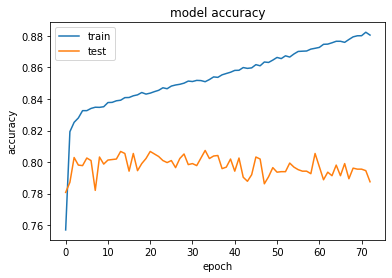

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.76      0.83      0.80      1560
           1       0.82      0.74      0.78      1560

    accuracy                           0.79      3120
   macro avg       0.79      0.79      0.79      3120
weighted avg       0.79      0.79      0.79      3120



In [21]:
model = keras_RN(x_train_locs_40, y_train_locs_40, x_test_locs_5, y_test_locs_5, activation="tanh", loss="mean_squared_error", optimizer=optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True))

In [22]:
model.save('/content/drive/Shareddrives/ReseauNeurones/resume_resultats/models/troncons_train_test_aAEI_sans_5locs_model1-2')

INFO:tensorflow:Assets written to: /content/drive/Shareddrives/ReseauNeurones/resume_resultats/models/troncons_train_test_aAEI_sans_5locs_model1-2/assets


(-0.5, 1.5, 1.5, -0.5)

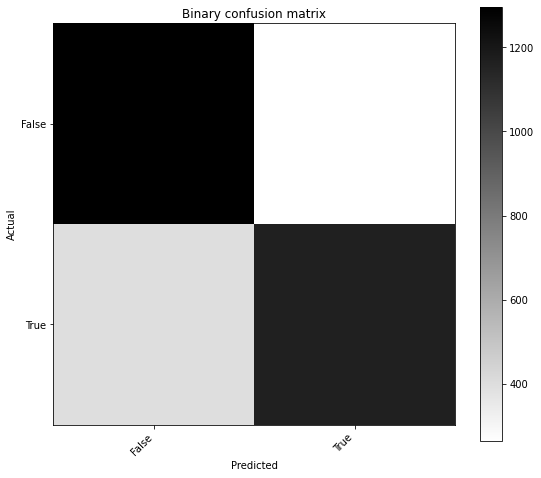

In [23]:
predictions = model.predict(np.array(x_test_locs_5), batch_size=100)
ConfusionMatrix(np.array(y_test_locs_5.argmax(axis=1)), predictions.argmax(axis=1)).plot().axis('on')

In [24]:
print(len(x_train_locs_40), len(y_train_locs_40), len(fileNames))
print(len(x_test_locs_5), len(y_test_locs_5), len(fileNames_test))

24960 24960 24960
3120 3120 3120


# Entraînement en retirant 5 locuteurs - 3



In [25]:
path_input = 'drive/Shareddrives/ReseauNeurones/images_troncons/train_aA_et_EI/*/*'
locs = getListLocuteur(path_input)
locs_40 = locs[20:] + locs[:15]
locs_5 = locs[15:20]
comp_40 = 0
print(locs_5)
print(locs_40)
x_train_locs_40, y_train_locs_40 = [], []
x_test_locs_5, y_test_locs_5 = [], []
fileNames = []
fileNames_test = []
for locuteur in locs_40:
  for path in glb.glob(path_input):
    if locuteur in path.split('/')[-1]:
      label = path.split('/')[-2]
      x = cv2.imread(path, 0).astype(np.uint8)
      x = cv2.resize(x, (img_rows, img_cols))
      y = dicoLocs[label]
      x_train_locs_40.append(x)
      y_train_locs_40.append(y)
      fileNames.append(path.split('/')[-1])

#print(len(x_test_loc))
x_train_locs_40 = np.array(x_train_locs_40)
x_train_locs_40 = x_train_locs_40.reshape(-1, x_train_locs_40.shape[1],x_train_locs_40.shape[2],1)
x_train_locs_40 = x_train_locs_40.astype('float32')
x_train_locs_40 /= 255. 

y_train_locs_40 = np.array(y_train_locs_40)
y_train_locs_40 = to_categorical(y_train_locs_40, num_classes, dtype='float32')

for locuteur in locs_5:
  for path in glb.glob(path_input):
    fileName = path.split('/')[-1]
    if locuteur in fileName:
      label = path.split('/')[-2]
      x = cv2.imread(path, 0).astype(np.uint8)
      x = cv2.resize(x, (img_rows, img_cols))
      y = dicoLocs[label]
      x_test_locs_5.append(x)
      y_test_locs_5.append(y)
      fileNames_test.append(fileName)
  
# #print(len(x_test_loc))
x_test_locs_5 = np.array(x_test_locs_5)
x_test_locs_5 = x_test_locs_5.reshape(-1, x_test_locs_5.shape[1],x_test_locs_5.shape[2],1)
x_test_locs_5 = x_test_locs_5.astype('float32')
x_test_locs_5 /= 255. 

y_test_locs_5 = np.array(y_test_locs_5)
y_test_locs_5 = to_categorical(y_test_locs_5, num_classes, dtype='float32')


print(len(x_train_locs_40), len(y_train_locs_40), len(fileNames))
print(len(x_test_locs_5), len(y_test_locs_5), len(fileNames_test))


['26_11_07_nb3_1_16', '26_11_07_nb3_2_16', '23_11_07_nb1_2_16', '26_11_07_nb1_1_16', '26_11_07_nb1_2_16']
['22_11_07_nb2_1_16', '22_11_07_nb2_2_16', '23_11_07_nb1_1_16', '20_11_07_nb1_2_16', '22_11_07_nb1_1_16', '22_11_07_nb1_2_16', '16_11_07_nb2_1_16', '16_11_07_nb2_2_16', '20_11_07_nb1_1_16', '14_11_07_nb2_1_16', '14_11_07_nb2_2_16', '16_11_07_nb1_1_16', '16_11_07_nb1_2_16', '05_12_07_nb1_2_16', '14_11_07_nb1_1_16', '14_11_07_nb1_2_16', '04_12_07_nb3_1_16', '04_12_07_nb3_2_16', '05_12_07_nb1_1_16', '04_12_07_nb1_2_16', '04_12_07_nb2_1_16', '04_12_07_nb2_2_16', '03_12_07_nb1_1_16', '03_12_07_nb1_2_16', '04_12_07_nb1_1_16', '29_11_07_nb2_1_16', '29_11_07_nb2_2_16', '30_11_07_nb1_1_16', '30_11_07_nb1_2_16', '28_11_07_nb2_1_16', '28_11_07_nb2_2_16', '29_11_07_nb1_2_16', '27_11_07_nb2_2_16', '28_11_07_nb1_1_16', '28_11_07_nb1_2_16', '27_11_07_nb1_1_16', '27_11_07_nb1_2_16', '27_11_07_nb2_1_16', '26_11_07_nb2_1_16', '26_11_07_nb2_2_16']
24960 24960 24960
3120 3120 3120


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 64)          51264     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 2050      
Total params: 54,146
Trainable params: 54,146
Non-trainable params: 0
__________________________________________________

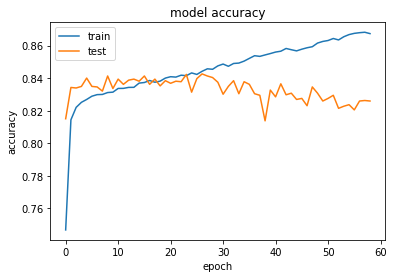

              precision    recall  f1-score   support

           0       0.82      0.84      0.83      1560
           1       0.83      0.82      0.82      1560

    accuracy                           0.83      3120
   macro avg       0.83      0.83      0.83      3120
weighted avg       0.83      0.83      0.83      3120



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [26]:
model = keras_RN(x_train_locs_40, y_train_locs_40, x_test_locs_5, y_test_locs_5, activation="tanh", loss="mean_squared_error", optimizer=optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True))

In [27]:
model.save('/content/drive/Shareddrives/ReseauNeurones/resume_resultats/models/troncons_train_test_aAEI_sans_5locs_model1-3')

INFO:tensorflow:Assets written to: /content/drive/Shareddrives/ReseauNeurones/resume_resultats/models/troncons_train_test_aAEI_sans_5locs_model1-3/assets


In [28]:
model = tf.keras.models.load_model('/content/drive/Shareddrives/ReseauNeurones/resume_resultats/models/troncons_train_test_aAEI_sans_5locs_model1-3')

(-0.5, 1.5, 1.5, -0.5)

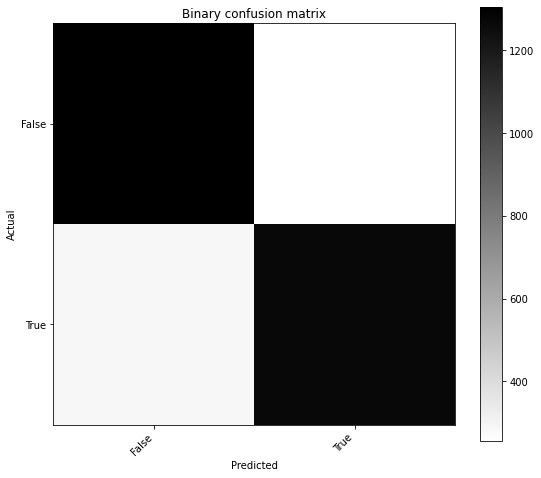

In [29]:
predictions = model.predict(np.array(x_test_locs_5), batch_size=100)
ConfusionMatrix(np.array(y_test_locs_5.argmax(axis=1)), predictions.argmax(axis=1)).plot().axis('on')

In [30]:
print(len(x_train_locs_40), len(y_train_locs_40), len(fileNames))
print(len(x_test_locs_5), len(y_test_locs_5), len(fileNames_test))

24960 24960 24960
3120 3120 3120


# Entraînement en retirant 5 locuteurs - 4



In [31]:
path_input = 'drive/Shareddrives/ReseauNeurones/images_troncons/train_aA_et_EI/*/*'
locs = getListLocuteur(path_input)
locs_40 = locs[:40]
locs_5 = locs[40:]
comp_40 = 0
print(locs_5)
print(locs_40)
x_train_locs_40, y_train_locs_40 = [], []
x_test_locs_5, y_test_locs_5 = [], []
fileNames = []
fileNames_test = []
for locuteur in locs_40:
  for path in glb.glob(path_input):
    if locuteur in path.split('/')[-1]:
      label = path.split('/')[-2]
      x = cv2.imread(path, 0).astype(np.uint8)
      x = cv2.resize(x, (img_rows, img_cols))
      y = dicoLocs[label]
      x_train_locs_40.append(x)
      y_train_locs_40.append(y)
      fileNames.append(path.split('/')[-1])

#print(len(x_test_loc))
x_train_locs_40 = np.array(x_train_locs_40)
x_train_locs_40 = x_train_locs_40.reshape(-1, x_train_locs_40.shape[1],x_train_locs_40.shape[2],1)
x_train_locs_40 = x_train_locs_40.astype('float32')
x_train_locs_40 /= 255. 

y_train_locs_40 = np.array(y_train_locs_40)
y_train_locs_40 = to_categorical(y_train_locs_40, num_classes, dtype='float32')

for locuteur in locs_5:
  for path in glb.glob(path_input):
    fileName = path.split('/')[-1]
    if locuteur in fileName:
      label = path.split('/')[-2]
      x = cv2.imread(path, 0).astype(np.uint8)
      x = cv2.resize(x, (img_rows, img_cols))
      y = dicoLocs[label]
      x_test_locs_5.append(x)
      y_test_locs_5.append(y)
      fileNames_test.append(fileName)
  
# #print(len(x_test_loc))
x_test_locs_5 = np.array(x_test_locs_5)
x_test_locs_5 = x_test_locs_5.reshape(-1, x_test_locs_5.shape[1],x_test_locs_5.shape[2],1)
x_test_locs_5 = x_test_locs_5.astype('float32')
x_test_locs_5 /= 255. 

y_test_locs_5 = np.array(y_test_locs_5)
y_test_locs_5 = to_categorical(y_test_locs_5, num_classes, dtype='float32')


print(len(x_train_locs_40), len(y_train_locs_40), len(fileNames))
print(len(x_test_locs_5), len(y_test_locs_5), len(fileNames_test))


['04_12_07_nb2_1_16', '04_12_07_nb2_2_16', '03_12_07_nb1_1_16', '03_12_07_nb1_2_16', '04_12_07_nb1_1_16']
['29_11_07_nb2_1_16', '29_11_07_nb2_2_16', '30_11_07_nb1_1_16', '30_11_07_nb1_2_16', '28_11_07_nb2_1_16', '28_11_07_nb2_2_16', '29_11_07_nb1_2_16', '27_11_07_nb2_2_16', '28_11_07_nb1_1_16', '28_11_07_nb1_2_16', '27_11_07_nb1_1_16', '27_11_07_nb1_2_16', '27_11_07_nb2_1_16', '26_11_07_nb2_1_16', '26_11_07_nb2_2_16', '26_11_07_nb3_1_16', '26_11_07_nb3_2_16', '23_11_07_nb1_2_16', '26_11_07_nb1_1_16', '26_11_07_nb1_2_16', '22_11_07_nb2_1_16', '22_11_07_nb2_2_16', '23_11_07_nb1_1_16', '20_11_07_nb1_2_16', '22_11_07_nb1_1_16', '22_11_07_nb1_2_16', '16_11_07_nb2_1_16', '16_11_07_nb2_2_16', '20_11_07_nb1_1_16', '14_11_07_nb2_1_16', '14_11_07_nb2_2_16', '16_11_07_nb1_1_16', '16_11_07_nb1_2_16', '05_12_07_nb1_2_16', '14_11_07_nb1_1_16', '14_11_07_nb1_2_16', '04_12_07_nb3_1_16', '04_12_07_nb3_2_16', '05_12_07_nb1_1_16', '04_12_07_nb1_2_16']
24960 24960 24960
3120 3120 3120


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 8, 64)          51264     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 2050      
Total params: 54,146
Trainable params: 54,146
Non-trainable params: 0
__________________________________________________

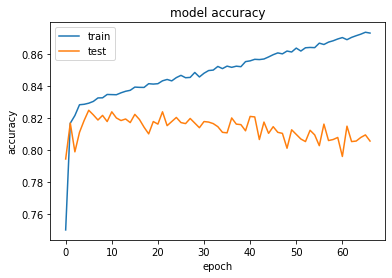

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.80      0.82      0.81      1560
           1       0.81      0.80      0.80      1560

    accuracy                           0.81      3120
   macro avg       0.81      0.81      0.81      3120
weighted avg       0.81      0.81      0.81      3120



In [32]:
model = keras_RN(x_train_locs_40, y_train_locs_40, x_test_locs_5, y_test_locs_5, activation="tanh", loss="mean_squared_error", optimizer=optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True))

In [33]:
model.save('/content/drive/Shareddrives/ReseauNeurones/resume_resultats/models/troncons_train_test_aAEI_sans_5locs_model1-4')

INFO:tensorflow:Assets written to: /content/drive/Shareddrives/ReseauNeurones/resume_resultats/models/troncons_train_test_aAEI_sans_5locs_model1-4/assets


(-0.5, 1.5, 1.5, -0.5)

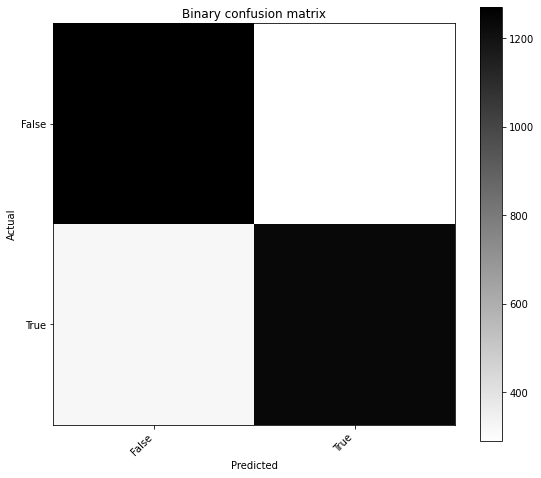

In [34]:
predictions = model.predict(np.array(x_test_locs_5), batch_size=100)
ConfusionMatrix(np.array(y_test_locs_5.argmax(axis=1)), predictions.argmax(axis=1)).plot().axis('on')

In [35]:
print(len(x_train_locs_40), len(y_train_locs_40), len(fileNames))
print(len(x_test_locs_5), len(y_test_locs_5), len(fileNames_test))

24960 24960 24960
3120 3120 3120


##Entraînement 2
    activation : relu
    model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 64)          51264     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 2050      
Total params: 54,146
Trainable params: 54,146
Non-trainable params: 0
__________________________________________________

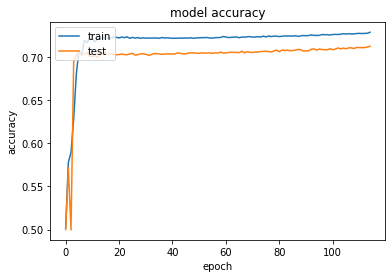

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.67      0.84      0.75      3240
           1       0.78      0.59      0.67      3240

    accuracy                           0.71      6480
   macro avg       0.73      0.71      0.71      6480
weighted avg       0.73      0.71      0.71      6480



In [ ]:
model = keras_RN(x_train, y_train, x_test, y_test, activation="relu", loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adadelta())

In [ ]:
model.save('/content/drive/Shareddrives/ReseauNeurones/resume_resultats/models/troncons_train_test_aAEI_model2')

INFO:tensorflow:Assets written to: /content/drive/Shareddrives/ReseauNeurones/resume_resultats/models/troncons_train_test_aAEI_model2/assets


In [ ]:
model = tf.keras.models.load_model('/content/drive/Shareddrives/ReseauNeurones/resume_resultats/models/troncons_train_test_aAEI_model2')

(-0.5, 1.5, 1.5, -0.5)

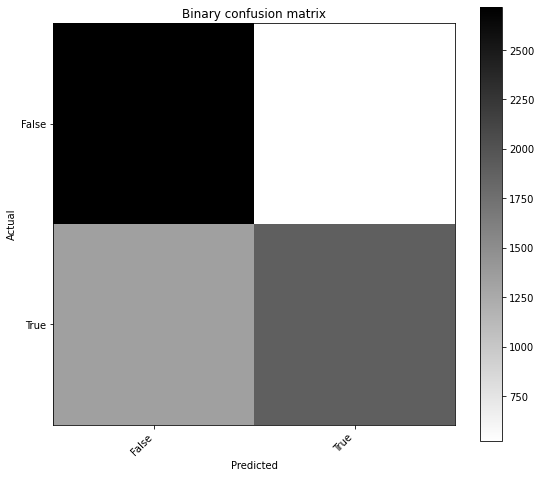

In [ ]:
predictions = model.predict(np.array(x_test), batch_size=100)
ConfusionMatrix(np.array(y_test.argmax(axis=1)), predictions.argmax(axis=1)).plot().axis('on')

In [ ]:
testLocuteur(model, "/content/drive/Shareddrives/ReseauNeurones/resume_resultats/troncons/train_test_aAEI/all_score_loc_entrainement2.csv", "/content/drive/Shareddrives/ReseauNeurones/images_troncons/test_aA_et_EI/*/*")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
testSegment(model, "/content/drive/Shareddrives/ReseauNeurones/resume_resultats/troncons/train_test_aAEI/all_score_seg_entrainement2.csv", "/content/drive/Shareddrives/ReseauNeurones/images_troncons/test_aA_et_EI/*/*")

['a', 'E', 'A', 'I']


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [ ]:
Y_test = np.argmax(y_test_troncons1, axis=1) # Convert one-hot to index
y_pred = model.predict_classes(x_test_troncons1)
resultat["1"] = getScoreLocuteur(classification_report(Y_test, y_pred))

# 2
Y_test = np.argmax(y_test_troncons2, axis=1) # Convert one-hot to index
y_pred = model.predict_classes(x_test_troncons2)
resultat["2"] = getScoreLocuteur(classification_report(Y_test, y_pred))

# 3
Y_test = np.argmax(y_test_troncons3, axis=1) # Convert one-hot to index
y_pred = model.predict_classes(x_test_troncons3)
resultat["3"] = getScoreLocuteur(classification_report(Y_test, y_pred))

getCSV(resultat, "/content/drive/Shareddrives/ReseauNeurones/resume_resultats/troncons/train_test_aAEI/all_score_tier_entrainement2.csv")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
proba = model.predict(x_test)
print(proba)

[[0.11786358 0.8821364 ]
 [0.4539708  0.5460292 ]
 [0.11786358 0.8821364 ]
 ...
 [0.11786358 0.8821364 ]
 [0.5196478  0.4803522 ]
 [0.3919948  0.60800517]]


In [ ]:
print(proba[0])
for i in proba[0]:
  print(f"{i:.6f}")

[0.11786358 0.8821364 ]
0.117864
0.882136


In [ ]:
resultat = dict()

for i in range(len(proba)):
  score = dict()
  score["son"] = fileNames[i].split('_')[6]
  score["tier"] = fileNames[i].split('_')[-1][0]
  score["contexte_gauche"] = fileNames[i].split('_')[8]
  score["contexte_droit"] = fileNames[i].split('_')[9]
  score["contextes"] = fileNames[i].split('_')[8] + "_" + fileNames[i].split('_')[9]
  score["temps_debut"] = fileNames[i].split('_')[-3]
  score["temps_fin"] = fileNames[i].split('_')[-2]
  score["proba_oral"] = f"{proba[i][0]:.6f}"
  score["proba_nasal"] = f"{proba[i][1]:.6f}"
  resultat[i+1] = score

getCSV(resultat, "drive/Shareddrives/ReseauNeurones/resume_resultats/troncons/train_test_aAEI/all_score_context_entrainement2.csv")

In [ ]:
resultat = dict()


##Entraînement 3
    activation : tanh
    model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])




Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 8, 64)          51264     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 2050      
Total params: 54,146
Trainable params: 54,146
Non-trainable params: 0
__________________________________________________

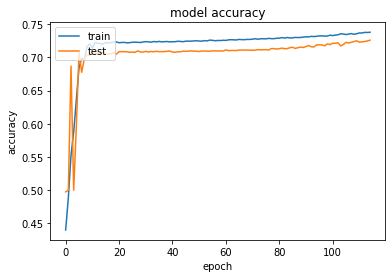

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.68      0.86      0.76      3240
           1       0.81      0.59      0.68      3240

    accuracy                           0.73      6480
   macro avg       0.74      0.73      0.72      6480
weighted avg       0.74      0.73      0.72      6480



In [ ]:
model = keras_RN(x_train, y_train, x_test, y_test, activation="tanh", loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adadelta())

In [ ]:
model.save('/content/drive/Shareddrives/ReseauNeurones/resume_resultats/models/troncons_train_test_aAEI_model3')

INFO:tensorflow:Assets written to: /content/drive/Shareddrives/ReseauNeurones/resume_resultats/models/troncons_train_test_aAEI_model3/assets


In [ ]:
model = tf.keras.models.load_model('/content/drive/Shareddrives/ReseauNeurones/resume_resultats/models/troncons_train_test_aAEI_model3')

(-0.5, 1.5, 1.5, -0.5)

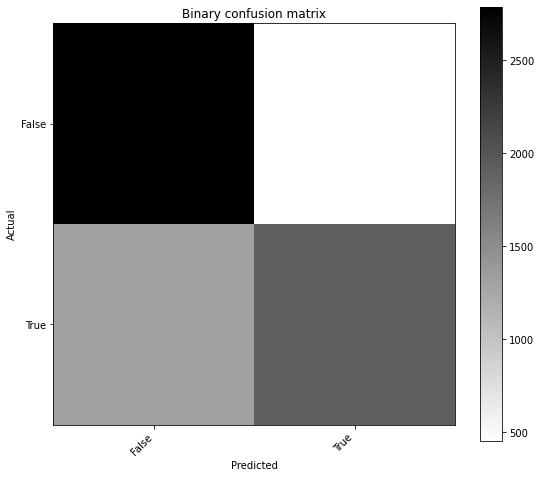

In [ ]:
predictions = model.predict(np.array(x_test), batch_size=100)
ConfusionMatrix(np.array(y_test.argmax(axis=1)), predictions.argmax(axis=1)).plot().axis('on')

In [ ]:
testLocuteur(model, "/content/drive/Shareddrives/ReseauNeurones/resume_resultats/troncons/train_test_aAEI/all_score_loc_entrainement3.csv", "/content/drive/Shareddrives/ReseauNeurones/images_troncons/test_aA_et_EI/*/*")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
testSegment(model, "/content/drive/Shareddrives/ReseauNeurones/resume_resultats/troncons/train_test_aAEI/all_score_seg_entrainement3.csv", "/content/drive/Shareddrives/ReseauNeurones/images_troncons/test_aA_et_EI/*/*")

['a', 'E', 'A', 'I']


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [ ]:
Y_test = np.argmax(y_test_troncons1, axis=1) # Convert one-hot to index
y_pred = model.predict_classes(x_test_troncons1)
resultat["1"] = getScoreLocuteur(classification_report(Y_test, y_pred))

# 2
Y_test = np.argmax(y_test_troncons2, axis=1) # Convert one-hot to index
y_pred = model.predict_classes(x_test_troncons2)
resultat["2"] = getScoreLocuteur(classification_report(Y_test, y_pred))

# 3
Y_test = np.argmax(y_test_troncons3, axis=1) # Convert one-hot to index
y_pred = model.predict_classes(x_test_troncons3)
resultat["3"] = getScoreLocuteur(classification_report(Y_test, y_pred))

getCSV(resultat, "/content/drive/Shareddrives/ReseauNeurones/resume_resultats/troncons/train_test_aAEI/all_score_tier_entrainement3.csv")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
proba = model.predict(x_test)
print(proba)

[[0.14445683 0.8555432 ]
 [0.46469888 0.53530115]
 [0.14445683 0.8555432 ]
 ...
 [0.14445683 0.85554314]
 [0.5065033  0.4934967 ]
 [0.36285642 0.63714355]]


In [ ]:
print(proba[0])
for i in proba[0]:
  print(f"{i:.6f}")

[0.14445683 0.8555432 ]
0.144457
0.855543


In [ ]:
resultat = dict()

for i in range(len(proba)):
  score = dict()
  score["son"] = fileNames[i].split('_')[6]
  score["tier"] = fileNames[i].split('_')[-1][0]
  score["contexte_gauche"] = fileNames[i].split('_')[8]
  score["contexte_droit"] = fileNames[i].split('_')[9]
  score["contextes"] = fileNames[i].split('_')[8] + "_" + fileNames[i].split('_')[9]
  score["temps_debut"] = fileNames[i].split('_')[-3]
  score["temps_fin"] = fileNames[i].split('_')[-2]
  score["proba_oral"] = f"{proba[i][0]:.6f}"
  score["proba_nasal"] = f"{proba[i][1]:.6f}"
  resultat[i+1] = score

getCSV(resultat, "drive/Shareddrives/ReseauNeurones/resume_resultats/troncons/train_test_aAEI/all_score_context_entrainement3.csv")

In [ ]:
resultat = dict()

##Entraînement 4
    activation : relu
    model.compile(loss='mean_squared_error', optimizer=sgd, metrics=['accuracy'])


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 8, 8, 64)          51264     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 2050      
Total params: 54,146
Trainable params: 54,146
Non-trainable params: 0
__________________________________________________

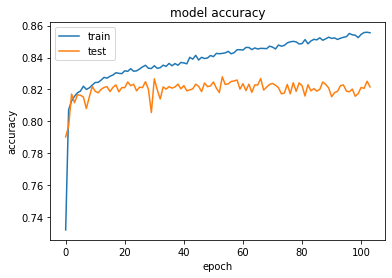

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.83      0.81      0.82      3240
           1       0.82      0.83      0.82      3240

    accuracy                           0.82      6480
   macro avg       0.82      0.82      0.82      6480
weighted avg       0.82      0.82      0.82      6480



In [ ]:
model = keras_RN(x_train, y_train, x_test, y_test, activation="relu", loss="mean_squared_error", optimizer=optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True))

In [ ]:
model.save('/content/drive/Shareddrives/ReseauNeurones/resume_resultats/models/troncons_train_test_aAEI_model4')

INFO:tensorflow:Assets written to: /content/drive/Shareddrives/ReseauNeurones/resume_resultats/models/troncons_train_test_aAEI_model4/assets


In [ ]:
model = tf.keras.models.load_model('/content/drive/Shareddrives/ReseauNeurones/resume_resultats/models/troncons_train_test_aAEI_model4')

(-0.5, 1.5, 1.5, -0.5)

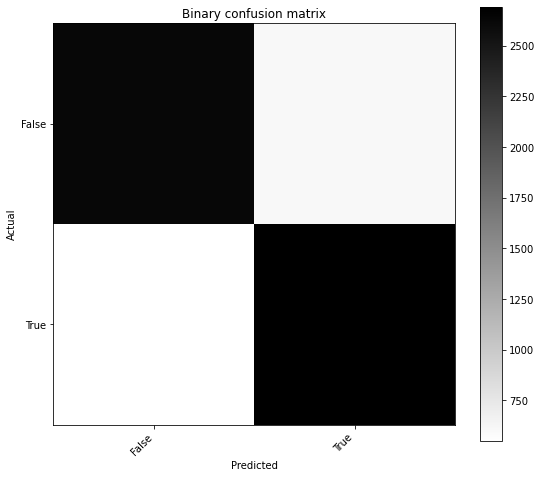

In [ ]:
predictions = model.predict(np.array(x_test), batch_size=100)
ConfusionMatrix(np.array(y_test.argmax(axis=1)), predictions.argmax(axis=1)).plot().axis('on')

In [ ]:
testLocuteur(model, "/content/drive/Shareddrives/ReseauNeurones/resume_resultats/troncons/train_test_aAEI/all_score_loc_entrainement4.csv", "/content/drive/Shareddrives/ReseauNeurones/images_troncons/test_aA_et_EI/*/*")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
testSegment(model, "/content/drive/Shareddrives/ReseauNeurones/resume_resultats/troncons/train_test_aAEI/all_score_seg_entrainement4.csv", "/content/drive/Shareddrives/ReseauNeurones/images_troncons/test_aA_et_EI/*/*")

['a', 'E', 'A', 'I']


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [ ]:
Y_test = np.argmax(y_test_troncons1, axis=1) # Convert one-hot to index
y_pred = model.predict_classes(x_test_troncons1)
resultat["1"] = getScoreLocuteur(classification_report(Y_test, y_pred))

# 2
Y_test = np.argmax(y_test_troncons2, axis=1) # Convert one-hot to index
y_pred = model.predict_classes(x_test_troncons2)
resultat["2"] = getScoreLocuteur(classification_report(Y_test, y_pred))

# 3
Y_test = np.argmax(y_test_troncons3, axis=1) # Convert one-hot to index
y_pred = model.predict_classes(x_test_troncons3)
resultat["3"] = getScoreLocuteur(classification_report(Y_test, y_pred))

getCSV(resultat, "/content/drive/Shareddrives/ReseauNeurones/resume_resultats/troncons/train_test_aAEI/all_score_tier_entrainement4.csv")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
proba = model.predict(x_test)
print(proba)

[[0.14839938 0.85160065]
 [0.49796885 0.50203115]
 [0.14839938 0.85160065]
 ...
 [0.14839938 0.85160065]
 [0.96017456 0.03982543]
 [0.01537916 0.9846208 ]]


In [ ]:
print(proba[0])
for i in proba[0]:
  print(f"{i:.6f}")

[0.14839938 0.85160065]
0.148399
0.851601


In [ ]:
resultat = dict()

for i in range(len(proba)):
  score = dict()
  score["son"] = fileNames[i].split('_')[6]
  score["tier"] = fileNames[i].split('_')[-1][0]
  score["contexte_gauche"] = fileNames[i].split('_')[8]
  score["contexte_droit"] = fileNames[i].split('_')[9]
  score["contextes"] = fileNames[i].split('_')[8] + "_" + fileNames[i].split('_')[9]
  score["temps_debut"] = fileNames[i].split('_')[-3]
  score["temps_fin"] = fileNames[i].split('_')[-2]
  score["proba_oral"] = f"{proba[i][0]:.6f}"
  score["proba_nasal"] = f"{proba[i][1]:.6f}"
  resultat[i+1] = score

getCSV(resultat, "drive/Shareddrives/ReseauNeurones/resume_resultats/troncons/train_test_aAEI/all_score_context_entrainement4.csv")

In [ ]:
resultat = dict()

##Entraînement 1
    activation : tanh
    model.compile(loss='mean_squared_error', optimizer=sgd, metrics=['accuracy'])

In [ ]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(5,5),
                 activation='tanh',
                 input_shape=(img_rows, img_cols, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (5, 5), activation='tanh'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))
model.summary()
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(loss='mean_squared_error', optimizer=sgd, metrics=['accuracy'])

# model.compile(loss=keras.losses.categorical_crossentropy,
#               optimizer=keras.optimizers.Adadelta(),
#               metrics=['accuracy'])

history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test), 
          callbacks=[es,mc])

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

best_model=keras.models.load_model('best_model.h5')
test_loss, test_acc = best_model.evaluate(x_test, y_test)
val_loss_list=history.history['val_loss']
best_val_loss_epoch=val_loss_list.index(min(val_loss_list))
val_acc_list = history.history["val_accuracy"]
best_val_acc_epoch = val_acc_list.index(max(val_acc_list))

print("loss on test set : ", test_loss)
print("accuracy on test set : ", test_acc)
print("\nBest epoch for the val_loss is : ", best_val_loss_epoch)
print("\nBest epoch for the val_acc is : ", best_val_acc_epoch)


In [ ]:
predictions = model.predict(np.array(x_test), batch_size=100)
ConfusionMatrix(np.array(y_test.argmax(axis=1)), predictions.argmax(axis=1)).plot().axis('on')

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

Y_test = np.argmax(y_test, axis=1) # Convert one-hot to index
y_pred = model.predict_classes(x_test)
print(classification_report(Y_test, y_pred))

##Entraînement 2
    activation : relu
    model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [ ]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(5,5),
                 activation='relu',
                 input_shape=(img_rows, img_cols, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (5, 5), activation='tanh'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))
model.summary()
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

# model.compile(loss='mean_squared_error', optimizer=sgd, metrics=['accuracy'])

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test), 
          callbacks=[es,mc])

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

best_model=keras.models.load_model('best_model.h5')
test_loss, test_acc = best_model.evaluate(x_test, y_test)
val_loss_list=history.history['val_loss']
best_val_loss_epoch=val_loss_list.index(min(val_loss_list))
val_acc_list = history.history["val_accuracy"]
best_val_acc_epoch = val_acc_list.index(max(val_acc_list))

print("loss on test set : ", test_loss)
print("accuracy on test set : ", test_acc)
print("\nBest epoch for the val_loss is : ", best_val_loss_epoch)
print("\nBest epoch for the val_acc is : ", best_val_acc_epoch)


In [ ]:
predictions = model.predict(np.array(x_test), batch_size=100)
ConfusionMatrix(np.array(y_test.argmax(axis=1)), predictions.argmax(axis=1)).plot().axis('on')

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
Y_test = np.argmax(y_test, axis=1) # Convert one-hot to index
y_pred = model.predict_classes(x_test)
print(classification_report(Y_test, y_pred))


##Entraînement 3
    activation : tanh
    model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])




In [ ]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(5,5),
                 activation='tanh',
                 input_shape=(img_rows, img_cols, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (5, 5), activation='tanh'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))
model.summary()
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

# model.compile(loss='mean_squared_error', optimizer=sgd, metrics=['accuracy'])

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test), 
          callbacks=[es,mc])

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

best_model=keras.models.load_model('best_model.h5')
test_loss, test_acc = best_model.evaluate(x_test, y_test)
val_loss_list=history.history['val_loss']
best_val_loss_epoch=val_loss_list.index(min(val_loss_list))
val_acc_list = history.history["val_accuracy"]
best_val_acc_epoch = val_acc_list.index(max(val_acc_list))

print("loss on test set : ", test_loss)
print("accuracy on test set : ", test_acc)
print("\nBest epoch for the val_loss is : ", best_val_loss_epoch)
print("\nBest epoch for the val_acc is : ", best_val_acc_epoch)


In [ ]:
predictions = model.predict(np.array(x_test), batch_size=100)
ConfusionMatrix(np.array(y_test.argmax(axis=1)), predictions.argmax(axis=1)).plot().axis('on')

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
Y_test = np.argmax(y_test, axis=1) # Convert one-hot to index
y_pred = model.predict_classes(x_test)
print(classification_report(Y_test, y_pred))

##Entraînement 4
    activation : relu
    model.compile(loss='mean_squared_error', optimizer=sgd, metrics=['accuracy'])


In [ ]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(5,5),
                 activation='relu',
                 input_shape=(img_rows, img_cols, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (5, 5), activation='tanh'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))
model.summary()
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(loss='mean_squared_error', optimizer=sgd, metrics=['accuracy'])

# model.compile(loss=keras.losses.categorical_crossentropy,
#               optimizer=keras.optimizers.Adadelta(),
#               metrics=['accuracy'])

history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test), 
          callbacks=[es,mc])

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

best_model=keras.models.load_model('best_model.h5')
test_loss, test_acc = best_model.evaluate(x_test, y_test)
val_loss_list=history.history['val_loss']
best_val_loss_epoch=val_loss_list.index(min(val_loss_list))
val_acc_list = history.history["val_accuracy"]
best_val_acc_epoch = val_acc_list.index(max(val_acc_list))

print("loss on test set : ", test_loss)
print("accuracy on test set : ", test_acc)
print("\nBest epoch for the val_loss is : ", best_val_loss_epoch)
print("\nBest epoch for the val_acc is : ", best_val_acc_epoch)


In [ ]:
predictions = model.predict(np.array(x_test), batch_size=100)
ConfusionMatrix(np.array(y_test.argmax(axis=1)), predictions.argmax(axis=1)).plot().axis('on')

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
Y_test = np.argmax(y_test, axis=1) # Convert one-hot to index
y_pred = model.predict_classes(x_test)
print(classification_report(Y_test, y_pred))



---

---





Et quelques autres entraînements pour essayer de voir d'où vient la différence au niveau de la progression dans un entraînement...


---

---





In [ ]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(5,5),
                 activation='relu',
                 input_shape=(img_rows, img_cols, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (5, 5), activation='tanh'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))
model.summary()
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

# model.compile(loss='mean_squared_error', optimizer=sgd, metrics=['accuracy'])

model.compile(loss='mean_squared_error',
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test), 
          callbacks=[es,mc])

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

best_model=keras.models.load_model('best_model.h5')
test_loss, test_acc = best_model.evaluate(x_test, y_test)
val_loss_list=history.history['val_loss']
best_val_loss_epoch=val_loss_list.index(min(val_loss_list))
val_acc_list = history.history["val_accuracy"]
best_val_acc_epoch = val_acc_list.index(max(val_acc_list))

print("loss on test set : ", test_loss)
print("accuracy on test set : ", test_acc)
print("\nBest epoch for the val_loss is : ", best_val_loss_epoch)
print("\nBest epoch for the val_acc is : ", best_val_acc_epoch)


In [ ]:
predictions = model.predict(np.array(x_test), batch_size=100)
ConfusionMatrix(np.array(y_test.argmax(axis=1)), predictions.argmax(axis=1)).plot().axis('on')

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
Y_test = np.argmax(y_test, axis=1) # Convert one-hot to index
y_pred = model.predict_classes(x_test)
print(classification_report(Y_test, y_pred))

In [ ]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(5,5),
                 activation='relu',
                 input_shape=(img_rows, img_cols, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (5, 5), activation='tanh'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))
model.summary()
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

# model.compile(loss='mean_squared_error', optimizer=sgd, metrics=['accuracy'])

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=sgd,
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test), 
          callbacks=[es,mc])

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

best_model=keras.models.load_model('best_model.h5')
test_loss, test_acc = best_model.evaluate(x_test, y_test)
val_loss_list=history.history['val_loss']
best_val_loss_epoch=val_loss_list.index(min(val_loss_list))
val_acc_list = history.history["val_accuracy"]
best_val_acc_epoch = val_acc_list.index(max(val_acc_list))

print("loss on test set : ", test_loss)
print("accuracy on test set : ", test_acc)
print("\nBest epoch for the val_loss is : ", best_val_loss_epoch)
print("\nBest epoch for the val_acc is : ", best_val_acc_epoch)


In [ ]:
predictions = model.predict(np.array(x_test), batch_size=100)
ConfusionMatrix(np.array(y_test.argmax(axis=1)), predictions.argmax(axis=1)).plot().axis('on')

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
Y_test = np.argmax(y_test, axis=1) # Convert one-hot to index
y_pred = model.predict_classes(x_test)
print(classification_report(Y_test, y_pred))